# Code Challenge 1 — B10 Reconstruction & Inference Pipeline

This notebook trains a lightweight CNN to reconstruct the missing Sentinel-2 B10 band and then applies a pre-trained EuroSAT classifier to Kaggle tiles after inserting the predicted band.

In [ ]:
from pathlib import Path
from datetime import datetime
import os, random, math, re, zipfile, platform

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import rasterio

from transformers import AutoImageProcessor, AutoModelForImageClassification


def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() and hasattr(torch, 'mps'):
        torch.mps.manual_seed(seed)  # type: ignore[attr-defined]
    os.environ["PYTHONHASHSEED"] = str(seed)


def resolve_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


RANDOM_SEED = 42
set_seed(RANDOM_SEED)

DEVICE = resolve_device()
print(f"Using device: {DEVICE}")


/Users/cyrilgabriele/anaconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def _env_path(var_name: str, default: Path) -> Path:
    default_path = Path(default)
    value = os.environ.get(var_name)
    return Path(value).expanduser() if value else default_path

REPO_ROOT = Path.cwd()
DATA_BASE = _env_path('EUROSAT_DATA_BASE', Path('/Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project'))
DATA_ROOT = _env_path('EUROSAT_DATA_ROOT', DATA_BASE / 'EuroSAT_MS')
DATA_ZIP = _env_path('EUROSAT_DATA_ZIP', DATA_BASE / 'EuroSAT_MS.zip')
MODELS_DIR = _env_path('EUROSAT_MODELS_DIR', REPO_ROOT / 'artifacts' / 'models')
PLOT_DIR = _env_path('EUROSAT_PLOTS_DIR', REPO_ROOT / 'artifacts' / 'plots')
B10_MODEL_DIR = _env_path('EUROSAT_B10_MODEL_DIR', MODELS_DIR / 'cirrus_cnn')
OUTPUT_DIR = _env_path('EUROSAT_OUTPUT_DIR', REPO_ROOT / 'outputs')
KAGGLE_TEST_DIR = _env_path('EUROSAT_KAGGLE_TEST_DIR', DATA_BASE / 'kaggle_data' / 'testset' / 'testset')

for path in (MODELS_DIR, PLOT_DIR, B10_MODEL_DIR, OUTPUT_DIR):
    path.mkdir(parents=True, exist_ok=True)

if not DATA_ROOT.exists():
    if DATA_ZIP.exists():
        print(f"Extracting dataset from {DATA_ZIP} ...")
        with zipfile.ZipFile(DATA_ZIP, 'r') as zip_ref:
            zip_ref.extractall(DATA_ROOT.parent)
    else:
        raise FileNotFoundError(
            f"Dataset directory {DATA_ROOT} not found. Update EUROSAT_DATA_ROOT or place an archive at {DATA_ZIP}."
        )
else:
    print(f"Dataset already available at {DATA_ROOT}")

RUN_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"RUN_TIMESTAMP={RUN_TIMESTAMP}")
print(f"Plots -> {PLOT_DIR}")
print(f"Models -> {MODELS_DIR}")
print(f"Outputs -> {OUTPUT_DIR}")


Dataset already available at /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/EuroSAT_MS
RUN_TIMESTAMP=20251110_182744
Plots -> /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/artifacts/plots
Models -> /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/artifacts/models
Outputs -> /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/outputs


In [ ]:
CLASS_NAMES = []
CIRRUS_TILE_PATHS = []

if DATA_ROOT.exists():
    class_dirs = sorted([d for d in DATA_ROOT.iterdir() if d.is_dir()])
    for d in class_dirs:
        label = len(CLASS_NAMES)
        CLASS_NAMES.append(d.name)
        for tif_path in sorted(d.glob('*.tif')):
            CIRRUS_TILE_PATHS.append(tif_path)
else:
    raise FileNotFoundError(f"{DATA_ROOT} not found. Extract the archive first.")

CLASS_TO_IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx: name for name, idx in CLASS_TO_IDX.items()}

print(f"Detected {len(CLASS_NAMES)} classes")
print(f"Total samples: {len(CIRRUS_TILE_PATHS)}")

TRAIN_BAND_ORDER = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B8A']
TEST_BAND_ORDER = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
DROP_BAND_NAME = 'B10'
DROP_BAND_INDEX = TRAIN_BAND_ORDER.index(DROP_BAND_NAME)
KEEP_IDX_13 = np.array([i for i, band in enumerate(TRAIN_BAND_ORDER) if band != DROP_BAND_NAME])
CANONICAL_12_BAND_ORDER = [band for band in TRAIN_BAND_ORDER if band != DROP_BAND_NAME]
KEEP_IDX_12 = np.arange(len(CANONICAL_12_BAND_ORDER))
TEST_TO_CANONICAL_12 = np.array([CANONICAL_12_BAND_ORDER.index(band) for band in TEST_BAND_ORDER], dtype=np.int64)
CIRRUS_SCALE = 10000.0
CIRRUS_MODEL = None


Detected 10 classes
Total samples: 27000


In [ ]:
def reorder_test_to_canonical(arr: np.ndarray) -> np.ndarray:
    """Reorders 12-band Sentinel-2 L2A (test layout) tiles to the canonical training layout without B10."""
    if arr.shape[0] != len(TEST_BAND_ORDER):
        raise ValueError(f"Expected array with {len(TEST_BAND_ORDER)} bands, got {arr.shape[0]}")
    out = np.empty_like(arr)
    for src_idx, dst_idx in enumerate(TEST_TO_CANONICAL_12):
        out[dst_idx] = arr[src_idx]
    return out


In [ ]:
class CirrusCNN(nn.Module):
    def __init__(self, in_channels: int = 12, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, 1, kernel_size=1, bias=True)
        )
        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
def sample_patches(arr: np.ndarray, num_patches: int, patch_size: int, rng: np.random.Generator):
    c, h, w = arr.shape
    ps = min(patch_size, h, w)
    patches_x = []
    patches_y = []
    for _ in range(num_patches):
        top = int(rng.integers(0, max(1, h - ps + 1)))
        left = int(rng.integers(0, max(1, w - ps + 1)))
        patch = arr[:, top:top + ps, left:left + ps]
        patches_x.append(patch[KEEP_IDX_13])
        patches_y.append(patch[DROP_BAND_INDEX:DROP_BAND_INDEX + 1])
    return patches_x, patches_y


def _iter_patch_batches(tile_paths, patches_per_tile, patch_size, batch_size, rng: np.random.Generator, desc: str | None = None):
    if not tile_paths:
        return

    order = np.arange(len(tile_paths))
    rng.shuffle(order)
    iterator = order
    if desc is not None:
        iterator = tqdm(order, desc=desc, leave=False)
    batch_x, batch_y = [], []
    for idx in iterator:
        path = tile_paths[idx]
        with rasterio.open(path) as src:
            arr = src.read().astype(np.float32)
        if arr.shape[0] != 13:
            continue
        arr = np.clip(arr, 0.0, CIRRUS_SCALE) / CIRRUS_SCALE
        px, py = sample_patches(arr, patches_per_tile, patch_size, rng)
        for x_patch, y_patch in zip(px, py):
            batch_x.append(x_patch)
            batch_y.append(y_patch)
            if len(batch_x) == batch_size:
                yield torch.from_numpy(np.stack(batch_x)).float(), torch.from_numpy(np.stack(batch_y)).float()
                batch_x, batch_y = [], []
    if batch_x:
        yield torch.from_numpy(np.stack(batch_x)).float(), torch.from_numpy(np.stack(batch_y)).float()


def fit_cirrus_cnn(sample_paths,
                    patches_per_tile: int = 64,
                    patch_size: int = 64,
                    epochs: int = 5,
                    batch_size: int = 128,
                    lr: float = 5e-4,
                    val_fraction: float = 0.1,
                    max_tiles: int | None = None) -> dict:
    if not sample_paths:
        raise ValueError("No samples provided for cirrus CNN fitting")

    base_rng = np.random.default_rng(RANDOM_SEED)
    paths = list(sample_paths)
    if max_tiles is not None and len(paths) > max_tiles:
        idx = base_rng.choice(len(paths), size=max_tiles, replace=False)
        paths = [paths[i] for i in idx]
    base_rng.shuffle(paths)

    val_count = max(1, int(len(paths) * val_fraction))
    val_paths = paths[:val_count]
    train_paths = paths[val_count:]
    if not train_paths:
        raise ValueError("Not enough tiles for training after validation split")

    print(f"[CirrusCNN] Training on {len(train_paths)} tiles (+{len(val_paths)} val) with {patches_per_tile} patches per tile per epoch.")

    model = CirrusCNN().to(DEVICE)
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    best_state = None
    best_val = float('inf')

    history = []

    for epoch in range(1, epochs + 1):
        epoch_rng = np.random.default_rng(base_rng.integers(0, 1 << 32))
        model.train()
        train_loss = 0.0
        train_samples = 0
        for xb, yb in _iter_patch_batches(train_paths, patches_per_tile, patch_size, batch_size, epoch_rng, desc=f'Train patches (epoch {epoch})'):
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
            train_samples += xb.size(0)
        train_loss = train_loss / max(1, train_samples)

        val_rng = np.random.default_rng(epoch_rng.integers(0, 1 << 32))
        model.eval()
        val_loss = 0.0
        val_samples = 0
        with torch.no_grad():
            for xb, yb in _iter_patch_batches(val_paths, patches_per_tile, patch_size, batch_size, val_rng, desc=f'Val patches (epoch {epoch})'):
                xb = xb.to(DEVICE)
                yb = yb.to(DEVICE)
                preds = model(xb)
                val_loss += criterion(preds, yb).item() * xb.size(0)
                val_samples += xb.size(0)
        val_loss = val_loss / max(1, val_samples)
        print(f"[CirrusCNN] epoch {epoch}/{epochs} train={train_loss:.6f} val={val_loss:.6f}")

        history.append({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'train_samples': train_samples, 'val_samples': val_samples})

        if val_loss < best_val and val_samples > 0:
            best_val = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)

    eval_rng = np.random.default_rng(RANDOM_SEED + 1234)
    mae_sum = 0.0
    mse_sum = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for xb, yb in _iter_patch_batches(paths, patches_per_tile, patch_size, 256, eval_rng, desc='Evaluating cirrus CNN'):
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            preds = model(xb)
            mae_sum += torch.nn.functional.l1_loss(preds, yb, reduction='sum').item()
            mse_sum += torch.nn.functional.mse_loss(preds, yb, reduction='sum').item()
            count += xb.size(0)
    mae = mae_sum / max(1, count)
    rmse = math.sqrt(mse_sum / max(1, count))

    print(f"[CirrusCNN] Aggregated over ~{count} patches | MAE={mae:.6f} | RMSE={rmse:.6f}")

    if history:
        hist_df = pd.DataFrame(history)
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(hist_df['epoch'], hist_df['train_loss'], label='Train')
        ax.plot(hist_df['epoch'], hist_df['val_loss'], label='Val')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('SmoothL1 Loss')
        ax.set_title('CirrusCNN Training History')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.3)
        fig.tight_layout()
        plot_path = PLOT_DIR / f'cirrus_cnn_history_{RUN_TIMESTAMP}.png'
        fig.savefig(plot_path, dpi=180, bbox_inches='tight')
        plt.show()
        plt.close(fig)
        print(f"Saved CirrusCNN training plot to {plot_path}")

    return {
        'module': model,
        'mae': mae,
        'rmse': rmse,
        'scale': CIRRUS_SCALE,
    }


def synthesize_cirrus(arr: np.ndarray, band_order: str | None = None) -> np.ndarray:
    arr = np.asarray(arr, dtype=np.float32)
    if CIRRUS_MODEL is None:
        raise RuntimeError('CIRRUS_MODEL is None. Train or load the B10 reconstruction model before calling synthesize_cirrus.')

    if band_order is None:
        if arr.shape[0] == len(TRAIN_BAND_ORDER):
            band_order = 'train'
        elif arr.shape[0] == len(TEST_BAND_ORDER):
            band_order = 'test'
        elif arr.shape[0] == len(CANONICAL_12_BAND_ORDER):
            band_order = 'canonical_12'
        else:
            raise ValueError(f"Expected 12 or 13 bands, got {arr.shape}")

    scale = CIRRUS_MODEL['scale']
    if band_order == 'train':
        arr_scaled = np.clip(arr, 0.0, scale) / scale
        feats = arr_scaled[KEEP_IDX_13]
    elif band_order == 'test':
        reordered = reorder_test_to_canonical(arr)
        arr_scaled = np.clip(reordered, 0.0, scale) / scale
        feats = arr_scaled
    elif band_order == 'canonical_12':
        if arr.shape[0] != len(CANONICAL_12_BAND_ORDER):
            raise ValueError(f"Expected canonical 12-band array with shape (12, H, W), got {arr.shape}")
        arr_scaled = np.clip(arr, 0.0, scale) / scale
        feats = arr_scaled
    else:
        raise ValueError(f"Unsupported band_order: {band_order}")

    tensor = torch.from_numpy(feats).unsqueeze(0).to(DEVICE)
    module = CIRRUS_MODEL['module'].to(DEVICE)
    CIRRUS_MODEL['module'] = module
    module.eval()
    with torch.no_grad():
        pred = module(tensor).squeeze(0).squeeze(0).detach().cpu().numpy()
    pred = np.clip(pred, 0.0, 1.0) * scale
    return pred.astype(np.float32)


def pad_to_13_bands(arr: np.ndarray, band_order: str | None = None) -> np.ndarray:
    arr = np.asarray(arr, dtype=np.float32)
    if band_order is None:
        if arr.shape[0] == len(TRAIN_BAND_ORDER):
            band_order = 'train'
        elif arr.shape[0] == len(TEST_BAND_ORDER):
            band_order = 'test'
        elif arr.shape[0] == len(CANONICAL_12_BAND_ORDER):
            band_order = 'canonical_12'
        else:
            raise ValueError(f"Expected 12 or 13 bands, got {arr.shape}")

    if band_order == 'train':
        out = arr.copy()
        out[DROP_BAND_INDEX] = synthesize_cirrus(arr, band_order='train')
        return out

    if band_order == 'test':
        canonical = reorder_test_to_canonical(arr)
    elif band_order == 'canonical_12':
        if arr.shape[0] != len(CANONICAL_12_BAND_ORDER):
            raise ValueError(f"Expected canonical 12-band array with shape (12, H, W), got {arr.shape}")
        canonical = arr
    else:
        raise ValueError(f"Unsupported band_order: {band_order}")

    cirrus = synthesize_cirrus(canonical, band_order='canonical_12')
    return np.concatenate(
        [canonical[:DROP_BAND_INDEX], cirrus[np.newaxis, ...], canonical[DROP_BAND_INDEX:]],
        axis=0
    )


def robust_normalize(arr: np.ndarray) -> np.ndarray:
    arr = arr.astype(np.float32, copy=False)
    out = np.empty_like(arr)
    for i in range(arr.shape[0]):
        band = arr[i]
        lo, hi = np.percentile(band, [2, 98])
        if hi > lo:
            band = (band - lo) / (hi - lo)
        else:
            min_v, max_v = band.min(), band.max()
            if max_v > min_v:
                band = (band - min_v) / (max_v - min_v)
            else:
                band = np.zeros_like(band)
        out[i] = np.clip(band, 0.0, 1.0)
    return out




[CirrusCNN] Training on 24300 tiles (+2700 val) with 64 patches per tile per epoch.


[CirrusCNN] epoch 1/1 train=0.000277 val=0.000001


[CirrusCNN] Aggregated over ~1728000 patches | MAE=2.946925 | RMSE=0.071850


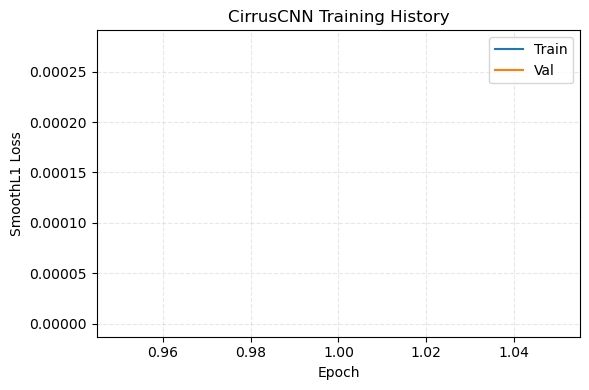

Saved CirrusCNN training plot to /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/artifacts/plots/cirrus_cnn_history_20251110_182744.png
Saved B10 reconstruction weights to /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/artifacts/models/cirrus_cnn/cirrus_cnn_20251110_182744.pt


In [ ]:
cirrus_paths = CIRRUS_TILE_PATHS
CIRRUS_MODEL = fit_cirrus_cnn(cirrus_paths, epochs=15, patches_per_tile=64, patch_size=64)
CIRRUS_MODEL['module'] = CIRRUS_MODEL['module'].to(DEVICE)
CIRRUS_MODEL['module'].eval()

cirrus_state_dict = {k: v.detach().cpu() for k, v in CIRRUS_MODEL['module'].state_dict().items()}

b10_bundle = {
    'state_dict': cirrus_state_dict,
    'mae': CIRRUS_MODEL['mae'],
    'rmse': CIRRUS_MODEL['rmse'],
    'scale': CIRRUS_MODEL['scale'],
    'drop_band_index': DROP_BAND_INDEX,
    'keep_idx_12': KEEP_IDX_12,
    'keep_idx_13': KEEP_IDX_13,
    'train_band_order': TRAIN_BAND_ORDER,
    'test_band_order': TEST_BAND_ORDER,
    'canonical_12_band_order': CANONICAL_12_BAND_ORDER,
}

b10_model_path = B10_MODEL_DIR / f'cirrus_cnn_{RUN_TIMESTAMP}.pt'
torch.save(b10_bundle, b10_model_path)
print(f"Saved B10 reconstruction weights to {b10_model_path}")

In [ ]:
MODEL_ID = 'Rhodham96/EuroSatCNN'
MODEL_SOURCE = 'auto'  # auto -> local first, fallback to HF
LOCAL_MODEL_DIR_CANDIDATES = [
    Path('/Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/Rhodham96-EuroSatCNN'),
    MODELS_DIR / 'Rhodham96-EuroSatCNN',
    Path('./local_models/Rhodham96-EuroSatCNN'),
    Path('./models/Rhodham96-EuroSatCNN'),
    Path.home() / 'models' / 'Rhodham96-EuroSatCNN',
]

LOCAL_MODEL_DIR = next((p for p in LOCAL_MODEL_DIR_CANDIDATES if p.exists()), LOCAL_MODEL_DIR_CANDIDATES[0])
LOCAL_MODEL_DEF = LOCAL_MODEL_DIR / 'model_def.py'
LOCAL_MODEL_WEIGHTS = LOCAL_MODEL_DIR / 'pytorch_model.bin'

print(f"Loading classifier {MODEL_ID} (source={MODEL_SOURCE})")
print(f"Resolved local directory: {LOCAL_MODEL_DIR}")
model = None
processor = None
image_size = 224

local_available = LOCAL_MODEL_DEF.exists() and LOCAL_MODEL_WEIGHTS.exists()

if MODEL_SOURCE in ('auto', 'local') and local_available:
    import importlib.util
    spec = importlib.util.spec_from_file_location('eurosat_local_model', LOCAL_MODEL_DEF)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    if not hasattr(module, 'EuroSATCNN'):
        raise AttributeError(f"EuroSATCNN class not found in {LOCAL_MODEL_DEF}")
    EuroSATCNN = module.EuroSATCNN
    model = EuroSATCNN(num_classes=len(CLASS_NAMES))
    state_dict = torch.load(LOCAL_MODEL_WEIGHTS, map_location='cpu')
    if isinstance(state_dict, dict) and 'state_dict' in state_dict:
        state_dict = state_dict['state_dict']
    model.load_state_dict(state_dict)
    image_size = getattr(model, 'image_size', getattr(model, 'input_resolution', 64))
    if not hasattr(model, 'image_size'):
        model.image_size = image_size
    print(f"Loaded local weights from {LOCAL_MODEL_WEIGHTS}")

if model is None and MODEL_SOURCE in ('auto', 'hf'):
    print(f"Falling back to Hugging Face hub for {MODEL_ID}")
    model = AutoModelForImageClassification.from_pretrained(MODEL_ID)
    image_size = getattr(model.config, 'image_size', image_size)
    try:
        processor = AutoImageProcessor.from_pretrained(MODEL_ID)
    except (OSError, IndexError) as hf_proc_err:
        print(f"Processor load failed: {hf_proc_err}")
        processor = None

if processor is None:
    print('Using fallback processor.')

    class EuroSatFallbackImageProcessor:
        def __init__(self, image_size: int = 224):
            self.image_size = image_size

        def _prep_single(self, image):
            if isinstance(image, np.ndarray):
                tensor = torch.from_numpy(image)
                if tensor.dtype != torch.float32:
                    tensor = tensor.float()
            elif torch.is_tensor(image):
                tensor = image.float()
            else:
                tensor = torch.from_numpy(np.asarray(image, dtype=np.float32))

            if tensor.ndim != 3:
                raise ValueError(f"Expected image with 3 dims, got {tuple(tensor.shape)}")

            if tensor.shape[0] not in (3, 13):
                tensor = tensor.permute(2, 0, 1)

            tensor = tensor.clamp(0.0, 1.0)

            if tensor.shape[1:] != (self.image_size, self.image_size):
                tensor = torch.nn.functional.interpolate(
                    tensor.unsqueeze(0),
                    size=(self.image_size, self.image_size),
                    mode='bilinear',
                    align_corners=False
                ).squeeze(0)

            return tensor

        def __call__(self, images, return_tensors=None):
            if isinstance(images, (list, tuple)):
                batch = torch.stack([self._prep_single(img) for img in images])
            else:
                batch = self._prep_single(images).unsqueeze(0)

            if return_tensors in (None, 'pt'):
                return {'pixel_values': batch}

            raise ValueError(f"Unsupported return_tensors value: {return_tensors!r}")

    processor = EuroSatFallbackImageProcessor(image_size=image_size)

if not hasattr(model, 'config'):
    from types import SimpleNamespace
    model.config = SimpleNamespace()

model.config.label2id = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
model.config.id2label = {idx: cls for cls, idx in model.config.label2id.items()}
model.config.num_labels = len(CLASS_NAMES)
model.config.image_size = image_size

model.to(DEVICE)
model.eval()
print('Classifier ready for inference.')

def get_model_logits(model, pixel_values):
    try:
        outputs = model(pixel_values=pixel_values)
    except TypeError:
        outputs = model(pixel_values)
    if isinstance(outputs, torch.Tensor):
        return outputs
    if isinstance(outputs, dict):
        if 'logits' in outputs:
            return outputs['logits']
        raise KeyError("Model output dict missing 'logits'")
    if hasattr(outputs, 'logits'):
        return outputs.logits
    raise RuntimeError('Model output does not contain logits')


Loading classifier Rhodham96/EuroSatCNN (source=auto)
Resolved local directory: /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/Rhodham96-EuroSatCNN
Loaded local weights from /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/Rhodham96-EuroSatCNN/pytorch_model.bin
Using fallback processor.
Classifier ready for inference.


In [ ]:
class EuroSATNPYDataset(Dataset):
    def __init__(self, paths, processor):
        self.paths = paths
        self.processor = processor

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        arr = np.load(path, allow_pickle=False)
        if arr.ndim == 3 and arr.shape[0] not in (12, 13) and arr.shape[-1] in (12, 13):
            arr = np.moveaxis(arr, -1, 0)
        arr = pad_to_13_bands(arr, band_order='test')
        arr = robust_normalize(arr)
        arr = np.moveaxis(arr, 0, -1)
        inputs = self.processor(images=arr, return_tensors='pt')
        pixel_values = inputs['pixel_values'].squeeze(0)
        sample_id = self._extract_id(path.stem)
        return {'pixel_values': pixel_values, 'id': sample_id}

    @staticmethod
    def _extract_id(stem: str) -> int:
        match = re.search(r'(\d+)$', stem)
        if match:
            return int(match.group(1))
        digits = ''.join(ch for ch in stem if ch.isdigit())
        return int(digits) if digits else -1


In [ ]:
TEST_ROOT = KAGGLE_TEST_DIR
if not TEST_ROOT.exists():
    raise FileNotFoundError(f"Expected test directory at {TEST_ROOT}")

npy_paths = sorted(TEST_ROOT.glob('*.npy'))
if not npy_paths:
    npy_paths = sorted(TEST_ROOT.glob('**/*.npy'))

if len(npy_paths) == 0:
    raise FileNotFoundError('No .npy files found in Kaggle test directory')

print(f"Found {len(npy_paths)} inference tiles")

BATCH_SIZE = 32
NUM_WORKERS = 0 if platform.system() == 'Darwin' else 2
PIN_MEMORY = DEVICE.type == 'cuda'

kaggle_dataset = EuroSATNPYDataset(npy_paths, processor)
kaggle_loader = DataLoader(
    kaggle_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

model.eval()
pred_ids = []
pred_indices = []
transfer_non_blocking = DEVICE.type == 'cuda'

with torch.no_grad():
    for batch in tqdm(kaggle_loader, desc='Kaggle inference'):
        pixel_values = batch['pixel_values'].to(DEVICE, non_blocking=transfer_non_blocking)
        logits = get_model_logits(model, pixel_values)
        preds = logits.argmax(dim=1).cpu().tolist()
        pred_indices.extend(preds)
        if isinstance(batch['id'], torch.Tensor):
            pred_ids.extend(batch['id'].cpu().tolist())
        else:
            pred_ids.extend(batch['id'])

pred_labels = [IDX_TO_CLASS[idx] for idx in pred_indices]
submission = pd.DataFrame({'test_id': pred_ids, 'label': pred_labels})
submission = submission.sort_values('test_id').reset_index(drop=True)

submission_name = f'submission_with_cirrus_{RUN_TIMESTAMP}.csv'
submission_path = OUTPUT_DIR / submission_name
submission.to_csv(submission_path, index=False)
print(f"Saved submission to {submission_path}")
print(submission.head())


Found 4232 inference tiles


Kaggle inference: 100%|██████████| 133/133 [00:12<00:00, 10.36it/s]

Saved submission to /Users/cyrilgabriele/Documents/School/00_Courses/02_ML/03_project/ML2025-Lab/cc_1/outputs/submission_with_cirrus_20251110_182744.csv
   test_id       label
0        0  Industrial
1        1       River
2        2       River
3        3  Industrial
4        4     Highway
